<img src="https://i.imgur.com/MmfIl9W.png">

<center><h1>🥼RSNA STR Pulmonary Embolism Detection🥼</h1></center>
<center><h2>Classify Pulmonary Embolism cases in chest CT scans</h2></center>
<p></p>
<p></p>


# 1. Introduction - what do I need to know

### #1. What is a Pulmonary Embolism (PE)?

* is a **blood clot** in the *lungs*
* it damages the lung due to restricted blood flow & decrease oxygen levels in the blood
* 1/3 people diagnosticated or untreated die from this disease
* source of info [here](https://www.healthline.com/health/pulmonary-embolus#:~:text=A%20pulmonary%20embolism%20is%20a,blockage%20can%20be%20life%2Dthreatening.)

> However, *correct* medical intervenion greatly increases the avoidance of permanent damage => hence the importance of correctly classifying the disease.

<img src="https://i.imgur.com/VBwwaOj.png" width=350>

### #2. How do we identify it? CTPA

* Chest CTPA - CT Pulmonary Angiography - the most common type of tool used to identify PE
* Each scan has hundreds of images that require detailed look into it

### #3. Data

> The data structure is as the schema below:
<img src="https://i.imgur.com/F8sLJQQ.png" width = 350>

* Images are groupes by **study** and **series**
* *Dicom* images: unique identifier is `SOPInstanceUID` and location looks like `<StudyInstanceUID>/<SeriesInstanceUID>/<SOPInstanceUID>.dcm`


* `train.csv` - containes *labels whch are targets* and some *informal* ones

### #4. Prediction
> Prediction is made at both **image level** and **study level**.

> For `.csv` data, there are labels that are noted as *exam-level*, which need to be predicted, and some that are noted as *informal*, which are NOT required to be predicted (meant as helpers). The informal labels are:
        * `qa_motion`
        * `qa_contrast`
        * `flow_artifact`
        * `true_filling_defect_not_pe`
        
*Note: `acute_pe` is implied by the lack of `chronic_pe` and `acute_and_chronic_pe` labels*

> There is also a *relationship* between labels that MUST be respected (as the below diagram shows - you can find it in the original dataset)
<img src="https://i.imgur.com/SZkdW4t.png" width=450>

> **SO: By looking only at the image, we need to predict all *exam-level* features, which *need* to also comply with the rules in the above schema. Oh boy.**

### Libraries 📚

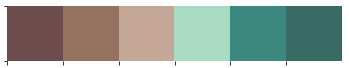

In [1]:
# Regular Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from scipy.stats import pearsonr
import tqdm

import pydicom # for DICOM images
from skimage.transform import resize
import copy
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#6C4C4D','#95715F','#C4A797','#A9DBC2','#3C887E', '#386B64']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=11)
plt.rc('ytick',labelsize=11)

In [2]:
# Centers the images

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 2. The Metadata - *.csv* files📋

## 2.1 Loading the data

In [3]:
basepath = "../input/rsna-str-pulmonary-embolism-detection"

# Import the data
train_csv = pd.read_csv(basepath + "/train.csv")
test_csv = pd.read_csv(basepath + "/test.csv")

# How many lines are in each dataframe?
print("Train: {:,} lines.".format(len(train_csv)), "\n" +
      "Test: {:,} lines.".format(len(test_csv)))

Train: 1,790,594 lines. 
Test: 146,853 lines.


In [4]:
df1_styler = train_csv.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = test_csv.head().style.set_table_attributes("style='display:inline'").set_caption('Test Data (rest Hidden)')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data StudyInstanceUID SeriesInstanceUID SOPInstanceUID pe_present_on_image negative_exam_for_pe qa_motion qa_contrast flow_artifact rv_lv_ratio_gte_1 rv_lv_ratio_lt_1 leftsided_pe chronic_pe true_filling_defect_not_pe rightsided_pe acute_and_chronic_pe central_pe indeterminate 
 
 0 
 6897fa9de148 
 2bfbb7fd2e8b 
 c0f3cb036d06 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 1 
 6897fa9de148 
 2bfbb7fd2e8b 
 f57ffd3883b6 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 2 
 6897fa9de148 
 2bfbb7fd2e8b 
 41220fda34a3 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 3 
 6897fa9de148 
 2bfbb7fd2e8b 
 13b685b4b14f 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 4 
 6897fa9de148 
 2bfbb7fd2e8b 
 be0b7524ffb4 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 Test Data (rest Hidden) StudyInstanceUID SeriesInstanceUID SOPInstanceUID 
 
 0 
 df06fad17bc3 
 857e3d760445 
 c3163725fcf6 
 
 
 1 
 df06fad17bc3 
 857e3d760445 
 d54a8daaf836 
 
 
 2 
 df06fad17bc3 
 857e3d760445 
 bdc531b699cd 
 
 
 3 
 df06fad17bc3 
 857e3d760445 
 9e6a68e27df0 
 
 
 4 
 df06fad17bc3 
 857e3d760445 
 25e3307ba7da

## 2.2 Missing Data❓

> No Missing Data, so we can proceed.

In [5]:
print("Train Data:", "\n" + 
      "Q: Are there any missing values?", "\n" +
      "A: {}".format(train_csv.isnull().values.any()), "\n")

print("Test Data:", "\n" + 
      "Q: Are there any missing values?", "\n" +
      "A: {}".format(test_csv.isnull().values.any()))

Train Data: 
Q: Are there any missing values? 
A: False 

Test Data: 
Q: Are there any missing values? 
A: False


## 2.3 Study, Series, Image

> I needed to understand a bit the format of the data. Below is a schema of how it looks.
<img src="https://i.imgur.com/CBF9g1W.png" width="500">

--- Train: 
Total Unique Studies&Series: 7,279
Min No. Images/Study: 63 
Max No. Images/Study: 1,083 
Avg No. Images/Study: 246


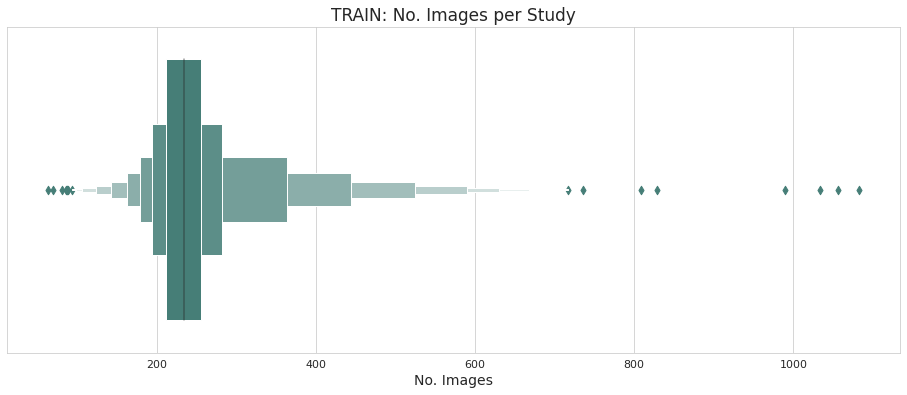

In [6]:
# Number of unique studies
print("--- Train:", "\n" +
      "Total Unique Studies&Series: {:,}".format(len(train_csv.groupby("StudyInstanceUID")["SeriesInstanceUID"].count())))

# Group by Study
data = train_csv.groupby("StudyInstanceUID")["SOPInstanceUID"].count().reset_index()
print("Min No. Images/Study: {:,}".format(data.min()[1]), "\n" +
      "Max No. Images/Study: {:,}".format(data.max()[1]), "\n" +
      "Avg No. Images/Study: {:,.0f}".format(round(data.mean()[0], 0)))

# Plot
plt.figure(figsize=(16, 6))
sns.boxenplot(x = "SOPInstanceUID", data=data, color=custom_colors[4])


plt.title("TRAIN: No. Images per Study", fontsize = 17)
plt.xlabel('No. Images', fontsize=14);

--- Test: 
Total Unique Studies&Series: 650
Min No. Images/Study: 87 
Max No. Images/Study: 407 
Avg No. Images/Study: 226


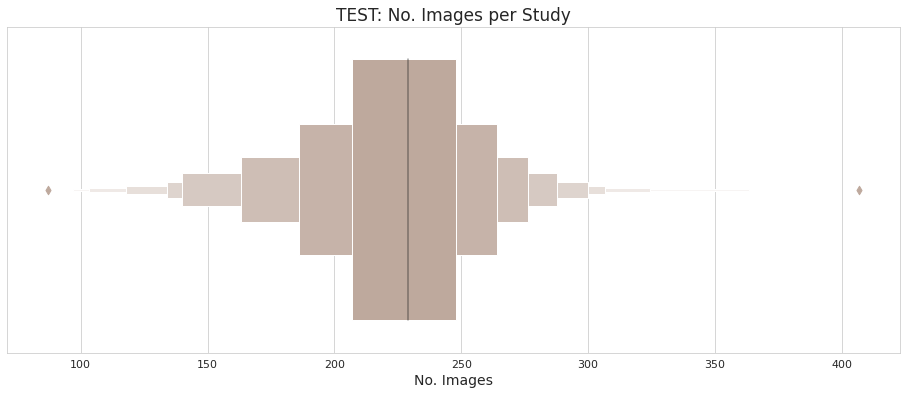

In [7]:
# Number of unique studies
print("--- Test:", "\n" +
      "Total Unique Studies&Series: {:,}".format(len(test_csv.groupby("StudyInstanceUID")["SeriesInstanceUID"].count())))

# Group by Study
data = test_csv.groupby("StudyInstanceUID")["SOPInstanceUID"].count().reset_index()
print("Min No. Images/Study: {:,}".format(data.min()[1]), "\n" +
      "Max No. Images/Study: {:,}".format(data.max()[1]), "\n" +
      "Avg No. Images/Study: {:,.0f}".format(round(data.mean()[0], 0)))

# Plot
plt.figure(figsize=(16, 6))
sns.boxenplot(x = "SOPInstanceUID", data=data, color=custom_colors[2])


plt.title("TEST: No. Images per Study", fontsize = 17)
plt.xlabel('No. Images', fontsize=14);

## 2.4 Labels that WILL BE Predicted

As stated before, using the `.dcm` images we'll predict a suite of features:
* 'pe_present_on_image'
* 'negative_exam_for_pe'
* 'rv_lv_ratio_gte_1'
* 'rv_lv_ratio_lt_1'
* 'leftsided_pe'
* 'chronic_pe'
* 'rightsided_pe'
* 'acute_and_chronic_pe'
* 'central_pe'
* 'indeterminate'

<div class="alert alert-block alert-info">  
A great discussion on what the features mean <a href="https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/183850">can be found here</a>. 
</div>

> **📌Note**: there are more cases of *right* side PE than *left* side. The least cases are *central*. There is a high percentage of PEs that are present in the study, but not in the particular image.

In [8]:
predict_variables = ['pe_present_on_image', 'negative_exam_for_pe', 'rv_lv_ratio_gte_1', 
                     'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 'rightsided_pe', 
                     'acute_and_chronic_pe', 'central_pe', 'indeterminate']

# Melt the prediction variables on a single column - so we can plot more easily the 10 variables
melt = train_csv[['SOPInstanceUID'] + predict_variables]
melt = pd.melt(melt, id_vars=['SOPInstanceUID'], value_vars=predict_variables)

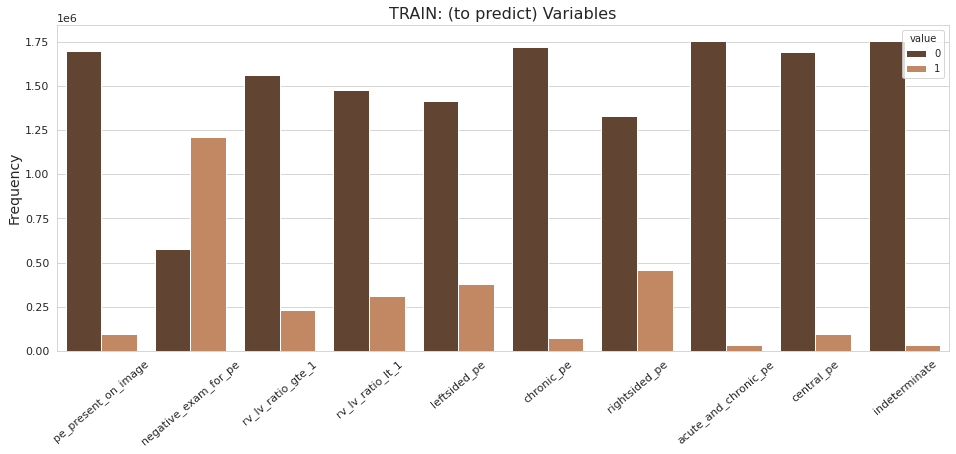

In [9]:
plt.figure(figsize=(16, 6))

a = sns.countplot(x=melt["variable"], hue=melt["value"], 
                  palette="copper")

plt.xticks(rotation=40)
plt.title("TRAIN: (to predict) Variables", fontsize = 16)
plt.xlabel("")
plt.ylabel("Frequency", fontsize=14);

## 2.5 Informational Labels (won't be predicted)

There are also 4 features that are intended only to be helpers.
* 'qa_motion'
* 'qa_contrast'
* 'flow_artifact'
* 'true_filling_defect_not_pe'

> **📌Note**: All features hase very low frequencies for *present* (or 1). These represent notes from radiologists, however we can't count on these, as there could be human error involved.

In [10]:
bonus_variables = ['qa_motion', 'qa_contrast', 'flow_artifact', 'true_filling_defect_not_pe']

# Melt the variables on a single column - so we can plot more easily the 4 variables
melt = train_csv[['SOPInstanceUID'] + bonus_variables]
melt = pd.melt(melt, id_vars=['SOPInstanceUID'], value_vars=bonus_variables)

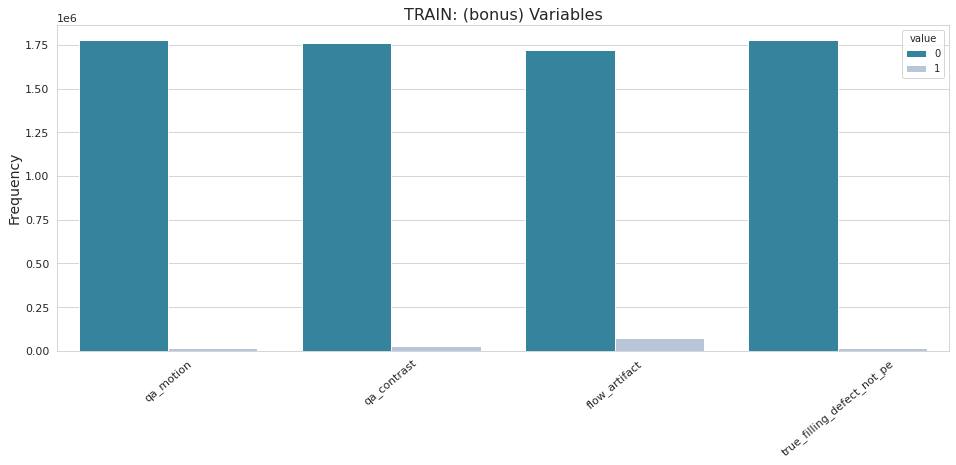

In [11]:
plt.figure(figsize=(16, 6))

a = sns.countplot(x=melt["variable"], hue=melt["value"], 
                  palette="PuBuGn_r")

plt.xticks(rotation=40)
plt.title("TRAIN: (bonus) Variables", fontsize = 16)
plt.xlabel("")
plt.ylabel("Frequency", fontsize=14);

# 3. DICOM Data📸

Now let's explore the `.dcm` files we were provided and to extract insights about it.

## 3.1 Sanity Check - verify number of *.dcm* files

In [12]:
# Create base director for train and test data
base_train = "../input/rsna-str-pulmonary-embolism-detection/train"
base_test = "../input/rsna-str-pulmonary-embolism-detection/test"

# --- TRAIN
# Count total number of files in each subdirectory in train and test
dcm_train = 0

# dirpath - the directory path in string
# dirnames - all main directories
# filenames - all subdirectories
for dirpath, dirnames, filenames in tqdm.tqdm(os.walk(base_train)):
    dcm_train += len(filenames)
        
# --- TEST
dcm_test = 0

for dirpath, dirnames, filenames in tqdm.tqdm(os.walk(base_test)):
    dcm_test += len(filenames)

14559it [01:16, 189.48it/s]
1301it [00:07, 184.06it/s]


*The number of .dcm images matches the number of rows in the .csv files.*

In [13]:
print("Train: total .dcm files - {:,}".format(dcm_train), "\n" +
      "Test: total .dcm files - {:,}".format(dcm_test))

Train: total .dcm files - 1,790,594 
Test: total .dcm files - 146,853


## 3.2 Visualize a DICOM image

> **📌Note**: all information regarding the patient has been removed for the images. Therefore, each *study* doesn't necessarly mean that is one person - it could be images from multiple people mixed in only 1 study.

Image Type.......: ['ORIGINAL', 'PRIMARY', 'AXIAL'] 
Modality.........: CT 
Rows.............: 512 
Columns..........: 512


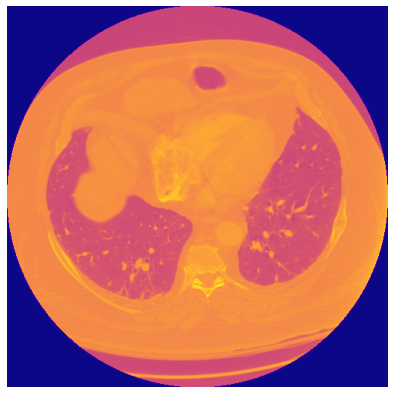

In [14]:
# Color of text
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'
    
path = "../input/rsna-str-pulmonary-embolism-detection/train/0003b3d648eb/d2b2960c2bbf/5eb3f6566b0f.dcm"
dataset = pydicom.dcmread(path)

print(bcolors.OKBLUE + "Image Type.......:", dataset.ImageType, "\n" +
      "Modality.........:", dataset.Modality, "\n" +
      "Rows.............:", dataset.Rows, "\n" +
      "Columns..........:", dataset.Columns)

plt.figure(figsize = (7, 7))
plt.imshow(dataset.pixel_array, cmap="plasma")
plt.axis('off');

### Let's see the difference between no present PE and PE present

In [15]:
# Get the base directory
base = "../input/rsna-str-pulmonary-embolism-detection/train"

# Get a sample of 2 images (1 with pe present and 1 with no pe present)
pe_yes = train_csv[train_csv["pe_present_on_image"] == 1].sample(random_state=33).reset_index()
pe_no = train_csv[train_csv["pe_present_on_image"] == 0].sample(random_state=101).reset_index()

# Get paths of these images
pe_yes_path = base + "/" + pe_yes["StudyInstanceUID"] + "/" + pe_yes["SeriesInstanceUID"] + "/" + pe_yes["SOPInstanceUID"] + ".dcm"
pe_no_path = base + "/" + pe_no["StudyInstanceUID"] + "/" + pe_no["SeriesInstanceUID"] + "/" + pe_no["SOPInstanceUID"] + ".dcm"

pe_yes_path = pe_yes_path[0]
pe_no_path = pe_no_path[0]

* Positive PE: There is a leftside PE, a righside PE and also a central PE (according with the .csv information)

In [16]:
pe_yes[["SOPInstanceUID", "pe_present_on_image", "leftsided_pe", "rightsided_pe", "central_pe"]]

,SOPInstanceUID,pe_present_on_image,leftsided_pe,rightsided_pe,central_pe
0,df82d4ba7cf2,1,1,1,1


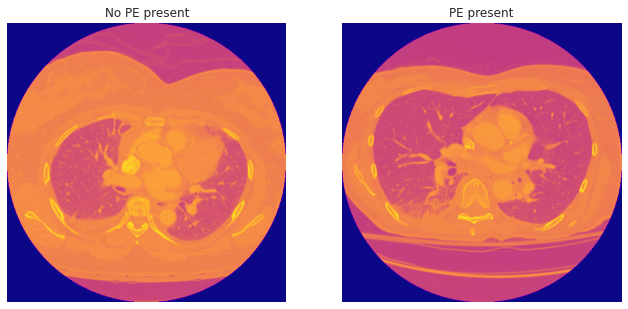

In [17]:
dataset_yes = pydicom.dcmread(pe_yes_path)
dataset_no = pydicom.dcmread(pe_no_path)


f, ax = plt.subplots(1, 2, figsize = (11, 11))

ax[0].imshow(dataset_no.pixel_array, cmap="plasma")
ax[1].imshow(dataset_yes.pixel_array, cmap="plasma")
ax[0].title.set_text("No PE present")
ax[1].title.set_text("PE present")
ax[0].axis('off')
ax[1].axis('off');

## 3.3 Visualize a set of images for a Study

> You can see how the lungs are expanding as they inhales air and contracting as they exhale.

In [18]:
# Study "0003b3d648eb"
study_dir = "../input/rsna-str-pulmonary-embolism-detection/train/0003b3d648eb/d2b2960c2bbf"
datasets = []

# Read in the Dataset
for dcm in os.listdir(study_dir):
    path = study_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))

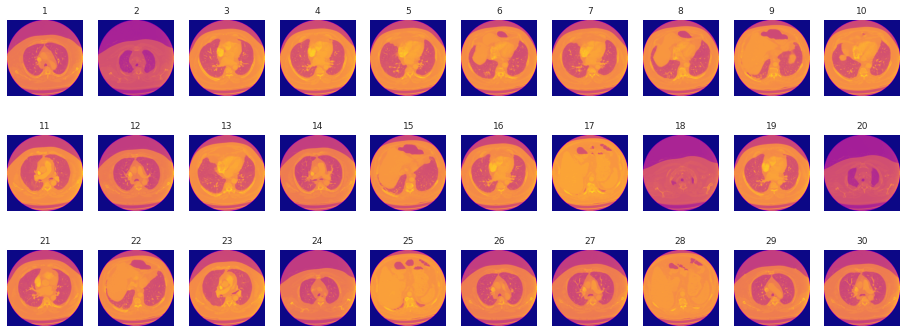

In [19]:
# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = datasets[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="plasma")
    plt.title(i, fontsize = 9)
    plt.axis('off');

# 4. Prepping the Data

<div class="alert alert-block alert-success">  
Great notebook that was used as inspiration <a href="https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing">was this one</a> by @Laura Fink. 
</div>

# Work in Progress⏳